In [1]:
from Preprocessing.AudioPreprocessor import AudioPreprocesser
from DatasetReaders.AudioDatset import AudioDataset
from skimage.segmentation import mark_boundaries
from DetectionModels.AudioCNN import CNNnetwork
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import nn
import torchaudio
import random
import captum
import torch
import lime

device= "cpu"

## 1. Dataset Initializing 

In [2]:
NUM_SAMPLES= int(3.100772*16000)
BATCH_SIZE= 128
SAMPLE_RATE= 16000  
NUM_OF_MELS= 128
WIN_LENGTH= int(0.016 * SAMPLE_RATE)
HOP_LENGTH= int(0.004 * SAMPLE_RATE) 
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-norm\for-norm\training\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-norm\for-norm\training\real"
CORRUPTED_PATHS=[
    "file8319.wav_16k.wav_norm.wav_mono.wav_silence.wav",
    "file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav",
    "file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav"
]

mel_spectogram= torchaudio.transforms.MelSpectrogram(
    sample_rate= SAMPLE_RATE,
    n_fft= WIN_LENGTH*2,
    hop_length= HOP_LENGTH,
    n_mels= NUM_OF_MELS,
    window_fn= torch.hamming_window,
    win_length= WIN_LENGTH
)

audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioPreprocesser
)

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 5000)
fake_sample= random.sample(fake_indices, 5000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_dataset= Subset(audio_dataset, subset_indices)

D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\dfd_env\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


## 2. Visualization for User

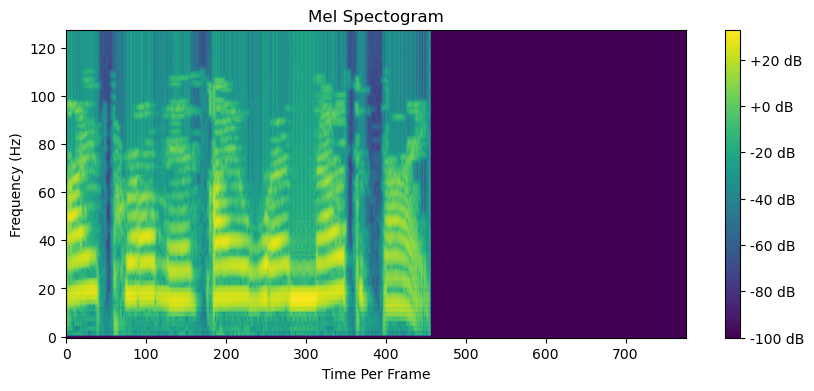

In [3]:
mel= small_dataset[0][0].squeeze(0).cpu()
mel_db= torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=0.0)

plt.figure(figsize=(10, 4))
plt.imshow(mel_db, origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time Per Frame")
plt.show()

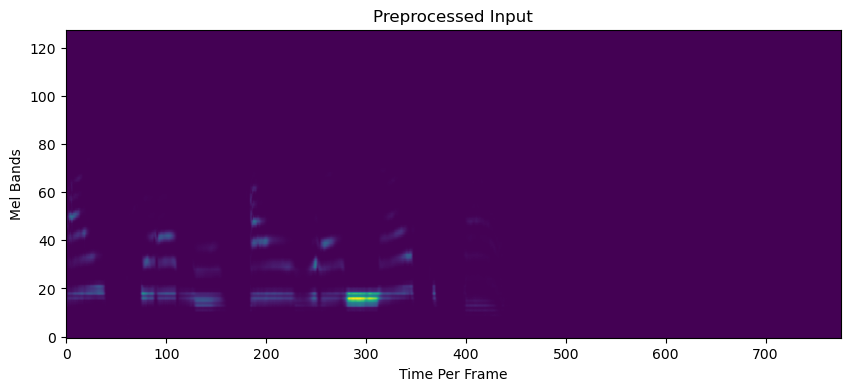

In [4]:
plt.figure(figsize=(10, 4))
plt.imshow(mel, origin='lower', aspect='auto')
plt.ylabel("Mel Bands")
plt.xlabel("Time Per Frame")
plt.title("Preprocessed Input")
plt.show()

In [5]:
model= CNNnetwork()
state_dict= torch.load("Audio_CNN.pth", weights_only=True)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [6]:
def predict_single(input_tensor, model=model,  device="cpu"):
    model.eval()
    model.to(device)

    # Add batch dimension if missing
    if input_tensor.dim() == 3:  # (C, H, W)
        input_tensor = input_tensor.unsqueeze(0)
    elif input_tensor.dim() == 2:  # (H, W)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)

    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = nn.Softmax(dim=1)(logits)
        preds = torch.argmax(probs, dim=1)

    return probs

In [7]:
predict_single(small_dataset[0][0])

tensor([[2.6800e-07, 1.0000e+00]])

In [8]:
from captum.attr import Saliency, IntegratedGradients, GradientShap, DeepLift

In [9]:
def forward_func(x,model=model):
    logits= model(x)
    return logits
    # return nn.Softmax(dim=1)(logits)

In [10]:
input_tensor= small_dataset[0][0].unsqueeze(0)
label= small_dataset[0][1]

In [11]:
from captum.attr import GradientShap

grad_shap = GradientShap(forward_func)

# Define a baseline — typically a zero tensor or noise around zero
baseline = torch.zeros_like(input_tensor)

# You can also add random noise for smoother attributions
baseline = baseline + torch.randn_like(input_tensor) #* 0.0001

# Compute attributions
attributions = grad_shap.attribute(
    input_tensor,
    baselines=baseline,
    target=label
)

In [12]:
saliency = Saliency(forward_func)
attributions = saliency.attribute(input_tensor, target=1)

D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\dfd_env\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


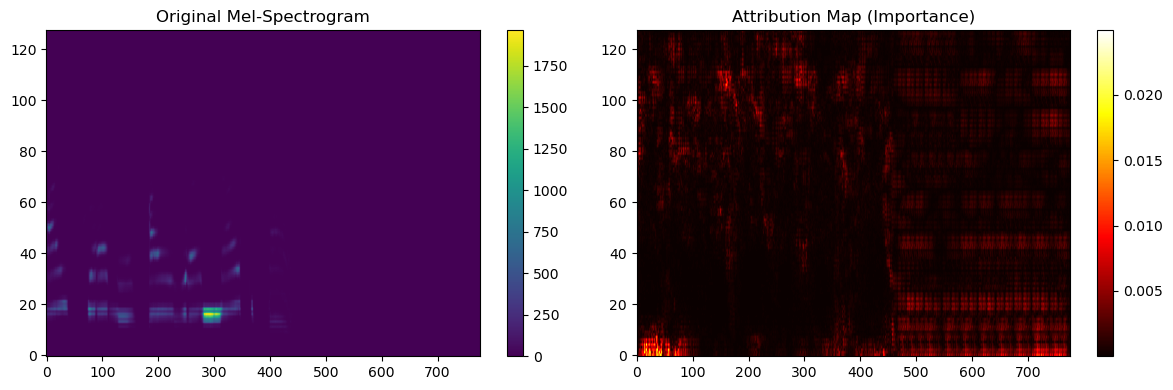

In [13]:
attr = attributions.squeeze().detach().numpy()
inp = input_tensor.squeeze().detach().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Original Mel-Spectrogram")
plt.imshow(inp, origin='lower', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Attribution Map (Importance)")
plt.imshow(attr, origin='lower', aspect='auto', cmap='hot')
plt.colorbar()
plt.tight_layout()
plt.show()

In [27]:
test= attributions.squeeze()
max_col= torch.max(test, dim=0)
mean_val= max_col[0].mean()
mean_max_cols_idx = [i for i, val in enumerate(max_col[0]) if val > mean_val]
mean_max_cols_vals = [max_col[0][i] for i in mean_max_cols_idx]
max_col


torch.return_types.max(
values=tensor([0.0045, 0.0050, 0.0051, 0.0047, 0.0103, 0.0099, 0.0074, 0.0068, 0.0075,
        0.0124, 0.0137, 0.0111, 0.0125, 0.0236, 0.0202, 0.0100, 0.0169, 0.0245,
        0.0127, 0.0131, 0.0162, 0.0249, 0.0158, 0.0225, 0.0204, 0.0068, 0.0149,
        0.0123, 0.0137, 0.0189, 0.0130, 0.0163, 0.0093, 0.0112, 0.0154, 0.0190,
        0.0184, 0.0186, 0.0159, 0.0130, 0.0224, 0.0226, 0.0152, 0.0218, 0.0141,
        0.0093, 0.0080, 0.0048, 0.0046, 0.0071, 0.0075, 0.0085, 0.0108, 0.0101,
        0.0126, 0.0127, 0.0222, 0.0196, 0.0051, 0.0046, 0.0071, 0.0056, 0.0061,
        0.0065, 0.0071, 0.0052, 0.0083, 0.0092, 0.0147, 0.0178, 0.0111, 0.0051,
        0.0131, 0.0148, 0.0130, 0.0100, 0.0056, 0.0087, 0.0097, 0.0088, 0.0043,
        0.0048, 0.0063, 0.0064, 0.0056, 0.0063, 0.0085, 0.0071, 0.0039, 0.0046,
        0.0051, 0.0046, 0.0050, 0.0031, 0.0038, 0.0027, 0.0044, 0.0050, 0.0026,
        0.0021, 0.0037, 0.0045, 0.0065, 0.0038, 0.0076, 0.0069, 0.0027, 0.0047,
        0

In [15]:
lengths = []
count = 1

for i in range(1, len(mean_max_cols_idx)):
    if mean_max_cols_idx[i] - mean_max_cols_idx[i-1] <= 3:
        count += 1
    else:
        lengths.append(count)
        count = 1

lengths.append(count)
mean_length = sum(lengths) / len(lengths)
mean_length

8.5

In [16]:
result = []
start_idx = 0  # Start of current sequence
count = 1      # Length of current sequence

for i in range(1, len(mean_max_cols_idx)):
    if  mean_max_cols_idx[i] - mean_max_cols_idx[i-1] <= 2 :
        count += 1
    else:
        if count > mean_length:
            result.append([start_idx, i-1])  # Store start and end indices
        start_idx = i
        count = 1

# Check the last sequence
if count > mean_length:
    result.append([start_idx, len(mean_max_cols_idx)-1])

print(result)

[[0, 42], [43, 51], [52, 68], [78, 96], [126, 134], [237, 263], [270, 282]]


In [18]:
HOP_DURATION= 0.004

In [19]:
result = [[x * HOP_DURATION, y * HOP_DURATION] for x, y in result]

In [20]:
result

[[0.0, 0.168],
 [0.17200000000000001, 0.20400000000000001],
 [0.20800000000000002, 0.272],
 [0.312, 0.384],
 [0.504, 0.536],
 [0.9480000000000001, 1.052],
 [1.08, 1.1280000000000001]]